In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [18]:
df=pd.read_csv('/content/Breast_cancer_dataset.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [19]:
le=LabelEncoder()
df['diagnosis']=le.fit_transform(df['diagnosis'])


In [20]:
df_cl=df.drop(['Unnamed: 32'],axis=1)
df_cl.tail()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.595,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,92751,0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [23]:
y=df_cl['diagnosis']
X=df_cl.drop(['diagnosis'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [24]:
xgb_model =XGBClassifier()
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_xgb.fit(X_train, y_train)
print("Best XGB Parameters:", random_search_xgb.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGB Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [25]:
rf_model = RandomForestClassifier()
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)
print("Best RF Parameters:", random_search_rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF Parameters: {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}


In [26]:
bestxgb=random_search_xgb.best_estimator_
bestrf=random_search_rf.best_estimator_
bestxgb.fit(X_train,y_train)
bestrf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=8,
                       n_estimators=200)

In [29]:
meta_model=LogisticRegression()
base_models = [('xgb', bestxgb), ('rf', bestrf)]
StackingClassifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)
StackingClassifier.fit(X_train,y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constr...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=10,
                                                       min_samples_split=8,
                                                       n_estimators=200))],
                   final_estimator=LogisticRegression())

In [30]:
y_pred=StackingClassifier.predict(X_test)
accuracy_score(y_test,y_pred)

0.9649122807017544

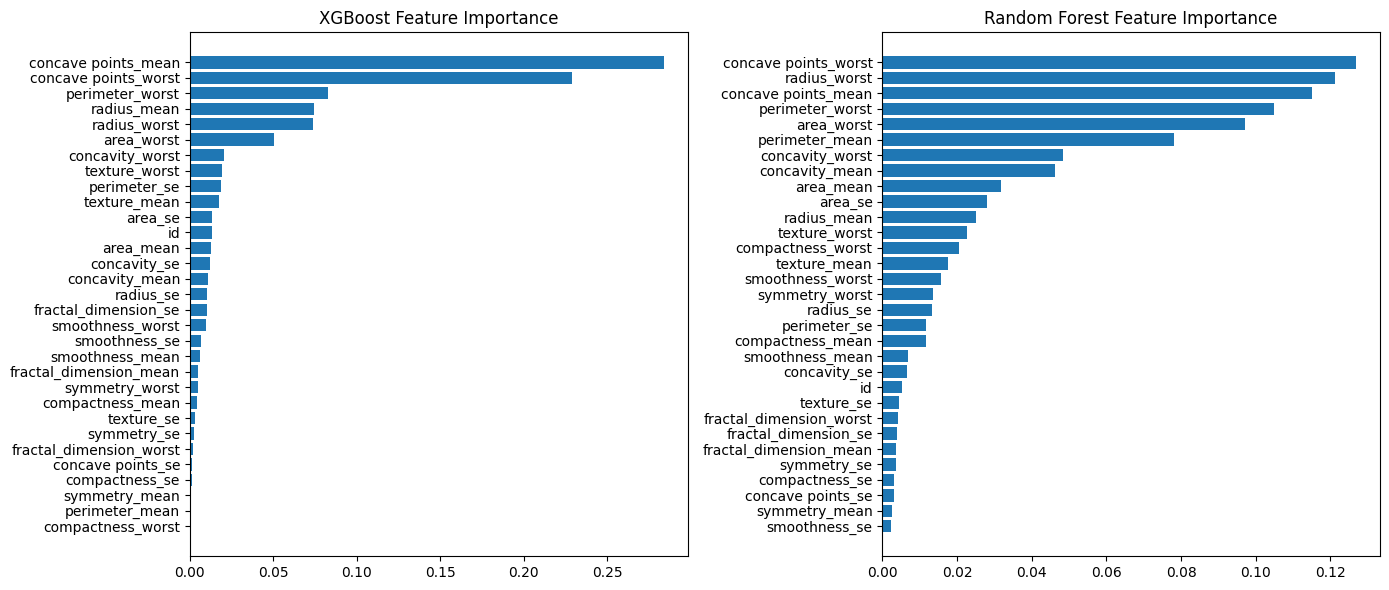

In [34]:
xgb_importance = bestxgb.feature_importances_
xgb_features = X.columns if hasattr(X, 'columns') else np.arange(X.shape[1])
xgb_importance_df = pd.DataFrame({'Feature': xgb_features, 'Importance': xgb_importance}).sort_values(by='Importance', ascending=False)
rf_importance = bestrf.feature_importances_
rf_features = X.columns if hasattr(X, 'columns') else np.arange(X.shape[1])
rf_importance_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_importance}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'])
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

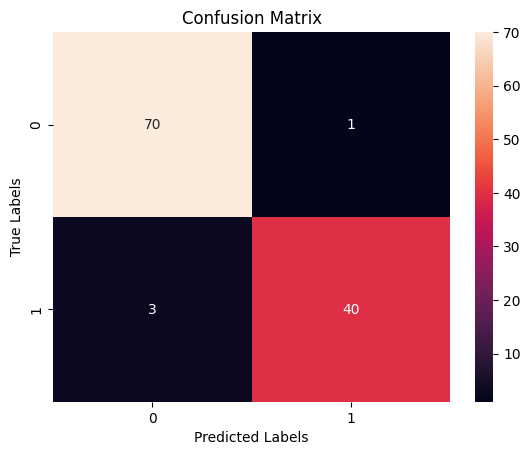

In [35]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()